CODE BLOCK: 1

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

CODE BLOCK: 2

In [45]:
# check if CUDA is available
cuda = torch.cuda.is_available()
print("CUDA available: ",cuda)

CUDA available:  True


CODE BLOCK: 3

In [46]:
# traiing data transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# test data transforms
test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# load datasets for trainig and testing
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


CODE BLOCK: 4

In [47]:
# batch size is number of samples processed before model is updated
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 5

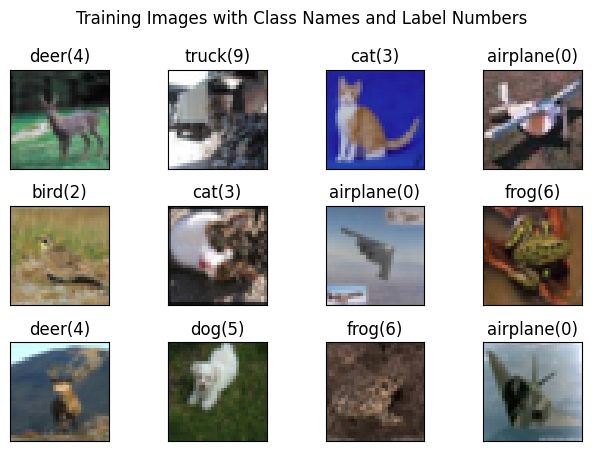

In [48]:
import matplotlib.pyplot as plt
import numpy as np
batch_data, batch_label = next(iter(train_loader))

# actual class names for CIFAR10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig = plt.figure()
plt.suptitle("Training Images with Class Names and Label Numbers")

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  image = np.transpose(batch_data[i].numpy(),(1,2,0))
  plt.imshow(image)
  plt.title(f"{class_names[batch_label[i].item()]}({batch_label[i].item()})")
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 6

In [49]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}


def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

CODE BLOCK: 7

In [50]:
# model.py

size1 = 16
size2 = 28
size3 = 36
drop_value = 0.15
nclasses = 10   # CIFAR10 data

class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()

        self.input_size = input_size

        self.conv_C1_C2 = nn.Sequential(
            nn.Conv2d(3, size1, 3, padding=1),
            nn.ReLU(),
            #nn.LayerNorm([size1, 32, 32]), # <--- Normalize activations over C, H, and W
            nn.GroupNorm(num_groups=1, num_channels=size1),  # Equivalent to LayerNorm
            nn.Dropout(drop_value),
            # C1
            nn.Conv2d(size1, size1, 3, stride=1, padding=1),
            nn.ReLU(),
            #nn.LayerNorm([size1, 32, 32]), # <--- Normalize activations over C, H, and W
            nn.GroupNorm(num_groups=1, num_channels=size1),  # Equivalent to LayerNorm
            nn.Dropout(drop_value),
            # C2
            nn.Conv2d(size1, size1, 3, stride=1, padding=1),
            nn.ReLU(),
            #nn.LayerNorm([size1, 32, 32]), # <--- Normalize activations over C, H, and W
            nn.GroupNorm(num_groups=1, num_channels=size1),  # Equivalent to LayerNorm
            nn.Dropout(drop_value),
        )

        # c3 P1
        self.conv_c3_P1 = nn.Sequential(
            nn.Conv2d(in_channels=size1, out_channels=nclasses, kernel_size=(1, 1), padding=0, bias=False),
            nn.MaxPool2d(2, 2),
        )

        # C4 C5 C6
        self.conv_C4_C5_C6 = nn.Sequential(
            # C4
            nn.Conv2d(nclasses, size2, 3, padding=1),
            nn.ReLU(),
            #nn.LayerNorm([size2, 16, 16]), # <--- Normalize activations over C, H, and W
            nn.GroupNorm(num_groups=1, num_channels=size2),  # Equivalent to LayerNorm
            nn.Dropout(drop_value),
            # C5
            nn.Conv2d(size2, size2, 3, stride=1, padding=1),
            nn.ReLU(),
            #nn.LayerNorm([size2, 16, 16]), # <--- Normalize activations over C, H, and W
            nn.GroupNorm(num_groups=1, num_channels=size2),  # Equivalent to LayerNorm
            nn.Dropout(drop_value),
            # C6
            nn.Conv2d(size2, size2, 3, stride=1, padding=1),
            nn.ReLU(),
            #nn.LayerNorm([size2, 16, 16]), # <--- Normalize activations over C, H, and W
            nn.GroupNorm(num_groups=1, num_channels=size2),  # Equivalent to LayerNorm
            nn.Dropout(drop_value),
        )

        # c7 P2
        self.conv_c7_P2 = nn.Sequential(
            nn.Conv2d(in_channels=size2, out_channels=nclasses, kernel_size=(1, 1), padding=0, bias=False),
            nn.MaxPool2d(2, 2),
        )

        # C8 C9 C10
        self.conv_C8_C9_C10 = nn.Sequential(
            # C8
            nn.Conv2d(nclasses, size3, 3, padding=1),
            nn.ReLU(),
            #nn.LayerNorm([size3, 8, 8]), # <--- Normalize activations over C, H, and W
            nn.GroupNorm(num_groups=1, num_channels=size3),  # Equivalent to LayerNorm
            nn.Dropout(drop_value),
            # C9
            nn.Conv2d(size3, size3, 3, stride=1, padding=1),
            nn.ReLU(),
            #nn.LayerNorm([size3, 8, 8]), # <--- Normalize activations over C, H, and W
            nn.GroupNorm(num_groups=1, num_channels=size3),  # Equivalent to LayerNorm
            nn.Dropout(drop_value),
            # C10
            nn.Conv2d(size3, size3, 3, stride=1, padding=1),
            nn.ReLU(),
            #nn.LayerNorm([size3, 8, 8]), # <--- Normalize activations over C, H, and W
            nn.GroupNorm(num_groups=1, num_channels=size3),  # Equivalent to LayerNorm
            nn.Dropout(drop_value),
        )

        # GAP  # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        )
        # C11
        self.conv_C11 = nn.Sequential(
            nn.Conv2d(in_channels=size3, out_channels=nclasses, kernel_size=(1, 1), padding=0, bias=False),
        )


    def forward(self, x):
        x = self.conv_C1_C2(x)
        x = self.conv_c3_P1(x)
        x = self.conv_C4_C5_C6(x)
        x = self.conv_c7_P2(x)
        x = self.conv_C8_C9_C10(x)
        x = self.gap(x)
        x = self.conv_C11(x)
        x = x.view(x.size(0), -1)

        x = F.log_softmax(x, dim=1)
        return x

from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
input_size = (3, 32, 32)
model = Net(input_size).to(device)
summary(model, input_size=input_size)

optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
#
criterion = nn.CrossEntropyLoss()
num_epochs = 20

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,320
              ReLU-6           [-1, 16, 32, 32]               0
         GroupNorm-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]           2,320
             ReLU-10           [-1, 16, 32, 32]               0
        GroupNorm-11           [-1, 16, 32, 32]              32
          Dropout-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 10, 32, 32]             160
        MaxPool2d-14           [-1, 10,

CODE BLOCK: 8

In [51]:
for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Epoch 1


Train: Loss=1.8134 Batch_id=390 Accuracy=20.58: 100%|██████████| 391/391 [00:12<00:00, 31.72it/s]


Test set: Average loss: 0.0160, Accuracy: 2749/10000 (27.49%)

Epoch 2


Train: Loss=1.7396 Batch_id=390 Accuracy=36.94: 100%|██████████| 391/391 [00:12<00:00, 32.12it/s]


Test set: Average loss: 0.0120, Accuracy: 4426/10000 (44.26%)

Epoch 3


Train: Loss=1.4019 Batch_id=390 Accuracy=43.74: 100%|██████████| 391/391 [00:13<00:00, 28.54it/s]


Test set: Average loss: 0.0116, Accuracy: 4719/10000 (47.19%)

Epoch 4


Train: Loss=1.3209 Batch_id=390 Accuracy=48.30: 100%|██████████| 391/391 [00:12<00:00, 31.48it/s]


Test set: Average loss: 0.0106, Accuracy: 5147/10000 (51.47%)

Epoch 5


Train: Loss=1.2582 Batch_id=390 Accuracy=52.21: 100%|██████████| 391/391 [00:12<00:00, 31.06it/s]


Test set: Average loss: 0.0103, Accuracy: 5345/10000 (53.45%)

Epoch 6


Train: Loss=1.2561 Batch_id=390 Accuracy=55.60: 100%|██████████| 391/391 [00:12<00:00, 31.46it/s]


Test set: Average loss: 0.0101, Accuracy: 5418/10000 (54.18%)

Epoch 7


Train: Loss=1.2035 Batch_id=390 Accuracy=58.13: 100%|██████████| 391/391 [00:12<00:00, 31.28it/s]


Test set: Average loss: 0.0087, Accuracy: 6142/10000 (61.42%)

Epoch 8


Train: Loss=1.0532 Batch_id=390 Accuracy=60.36: 100%|██████████| 391/391 [00:12<00:00, 30.46it/s]


Test set: Average loss: 0.0095, Accuracy: 5825/10000 (58.25%)

Epoch 9


Train: Loss=0.9644 Batch_id=390 Accuracy=62.24: 100%|██████████| 391/391 [00:12<00:00, 31.25it/s]


Test set: Average loss: 0.0078, Accuracy: 6539/10000 (65.39%)

Epoch 10


Train: Loss=1.1979 Batch_id=390 Accuracy=63.78: 100%|██████████| 391/391 [00:12<00:00, 31.07it/s]


Test set: Average loss: 0.0080, Accuracy: 6456/10000 (64.56%)

Epoch 11


Train: Loss=0.9233 Batch_id=390 Accuracy=65.24: 100%|██████████| 391/391 [00:12<00:00, 30.86it/s]


Test set: Average loss: 0.0079, Accuracy: 6587/10000 (65.87%)

Epoch 12


Train: Loss=1.0481 Batch_id=390 Accuracy=66.04: 100%|██████████| 391/391 [00:12<00:00, 31.13it/s]


Test set: Average loss: 0.0073, Accuracy: 6777/10000 (67.77%)

Epoch 13


Train: Loss=0.9674 Batch_id=390 Accuracy=66.84: 100%|██████████| 391/391 [00:12<00:00, 30.98it/s]


Test set: Average loss: 0.0070, Accuracy: 6888/10000 (68.88%)

Epoch 14


Train: Loss=0.7970 Batch_id=390 Accuracy=68.21: 100%|██████████| 391/391 [00:12<00:00, 31.31it/s]


Test set: Average loss: 0.0068, Accuracy: 7034/10000 (70.34%)

Epoch 15


Train: Loss=0.7595 Batch_id=390 Accuracy=68.50: 100%|██████████| 391/391 [00:12<00:00, 31.04it/s]


Test set: Average loss: 0.0066, Accuracy: 7091/10000 (70.91%)

Epoch 16


Train: Loss=0.6729 Batch_id=390 Accuracy=69.25: 100%|██████████| 391/391 [00:12<00:00, 31.14it/s]


Test set: Average loss: 0.0070, Accuracy: 6974/10000 (69.74%)

Epoch 17


Train: Loss=0.6870 Batch_id=390 Accuracy=69.71: 100%|██████████| 391/391 [00:12<00:00, 31.64it/s]


Test set: Average loss: 0.0066, Accuracy: 7108/10000 (71.08%)

Epoch 18


Train: Loss=0.9081 Batch_id=390 Accuracy=70.45: 100%|██████████| 391/391 [00:12<00:00, 31.40it/s]


Test set: Average loss: 0.0067, Accuracy: 7094/10000 (70.94%)

Epoch 19


Train: Loss=0.9725 Batch_id=390 Accuracy=70.78: 100%|██████████| 391/391 [00:12<00:00, 31.10it/s]


Test set: Average loss: 0.0069, Accuracy: 6950/10000 (69.50%)

Epoch 20


Train: Loss=0.9577 Batch_id=390 Accuracy=71.21: 100%|██████████| 391/391 [00:12<00:00, 31.12it/s]


Test set: Average loss: 0.0062, Accuracy: 7278/10000 (72.78%)



CODE BLOCK: 9

Text(0.5, 1.0, 'Test Accuracy')

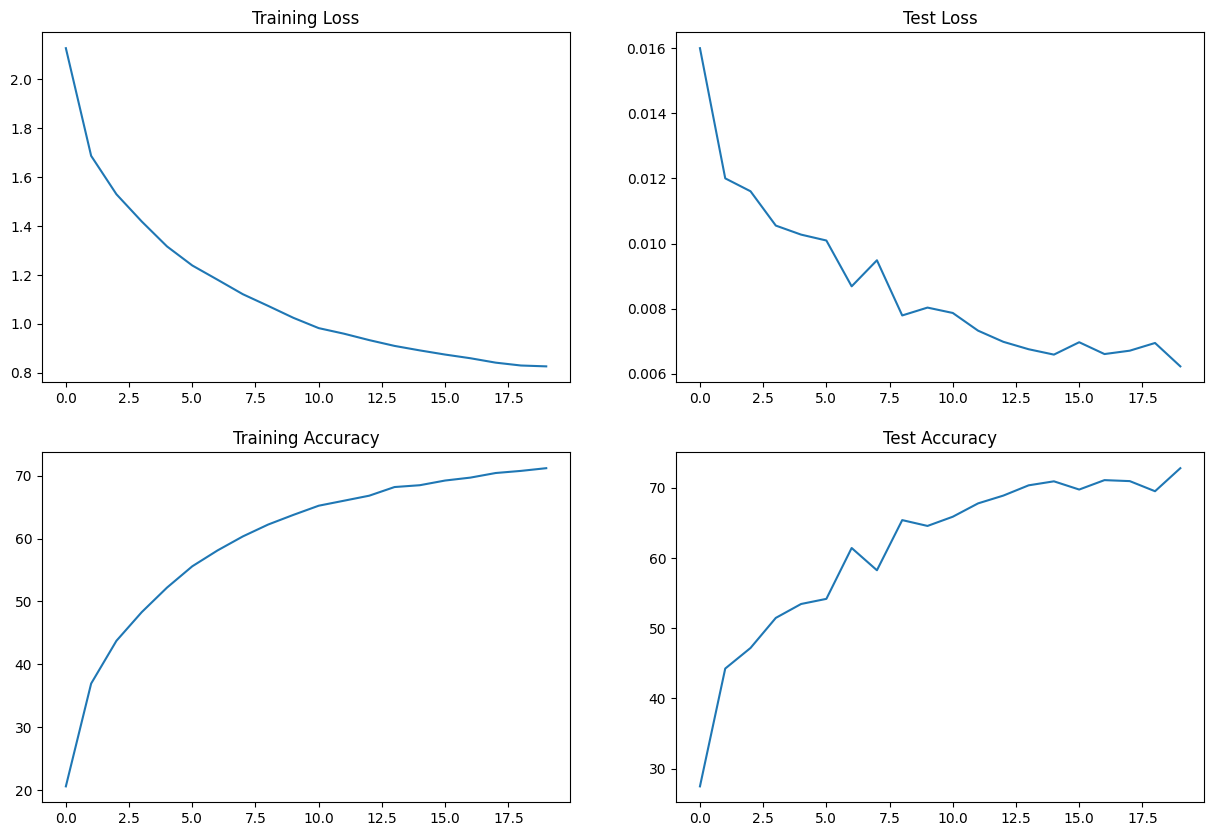

In [52]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

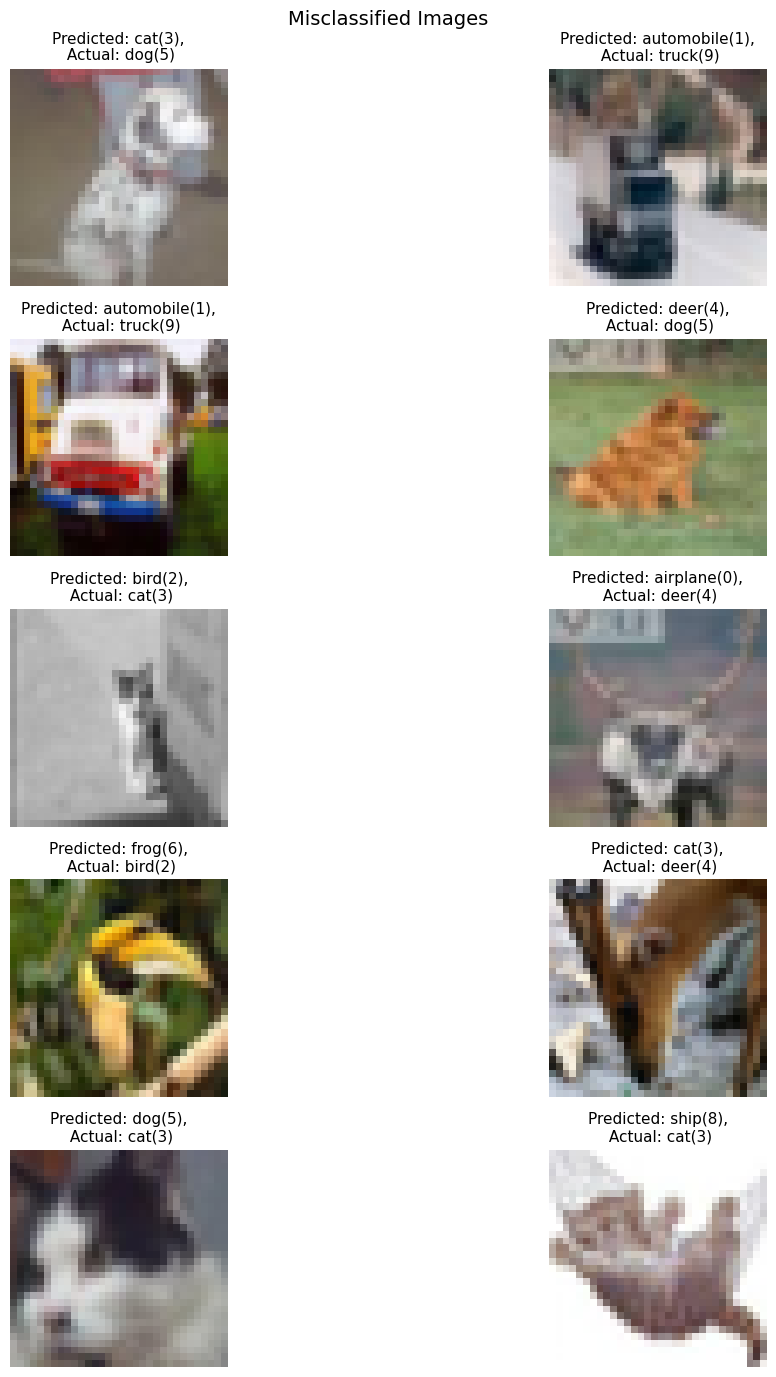

In [53]:
from torchvision import utils

# Set the model to evaluation mode
model.eval()


# List to store misclassified images and actual labels
misclassified_images = []
misclassified_labels = []
actual_labels = []

# Loop through the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        incorrect_mask = predicted != labels
        misclassified_images.append(images[incorrect_mask])
        misclassified_labels.append(predicted[incorrect_mask])
        actual_labels.append(labels[incorrect_mask])

# Concatenate the list of misclassified images
misclassified_images = torch.cat(misclassified_images)
misclassified_labels = torch.cat(misclassified_labels)
actual_labels        = torch.cat(actual_labels)
# Plot the misclassified images
plt.figure(figsize=(14, 14))
plt.suptitle("Misclassified Images", fontsize=14)

for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.imshow(np.transpose(misclassified_images[i].cpu().numpy(), (1, 2, 0)))
    mis_lab = misclassified_labels[i].item()
    act_lab = actual_labels[i].item()
    plt.title(f"Predicted: {class_names[mis_lab]}({mis_lab}),\n Actual: {class_names[act_lab]}({act_lab})", fontsize=11)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Save the misclassified images as a single image
from torchvision.utils import save_image

# Convert the misclassified images tensor to a grid
grid_image = utils.make_grid(misclassified_images, nrow=5)

# Save the grid image
utils.save_image(grid_image, 'misclassified_images.png')


In [54]:

min_train_loss_epoch = train_losses.index(min(train_losses)) + 1
min_test_loss_epoch = test_losses.index(min(test_losses)) + 1
best_train_acc_epoch = train_acc.index(max(train_acc)) + 1
best_test_acc_epoch = test_acc.index(max(test_acc)) + 1

print("Minimum training loss = {:.9f}% at epoch {}".format(min(train_losses), min_train_loss_epoch))
print("Minimum testing loss = {:.9f}% at epoch {}".format(min(test_losses), min_test_loss_epoch))
print("Best training accuracy = {:.2f}% at epoch {}".format(max(train_acc), best_train_acc_epoch))
print("Best testing accuracy = {:.2f}% at epoch {}".format(max(test_acc), best_test_acc_epoch))


Minimum training loss = 0.826521737% at epoch 20
Minimum testing loss = 0.006226229% at epoch 20
Best training accuracy = 71.21% at epoch 20
Best testing accuracy = 72.78% at epoch 20


##**Target**

- LayerNorm normalizes the features of each sample independently. It computes the mean and variance over all the elements in a layer for each sample.
- Usage of `nn.LayerNorm` leads to very large number of parameters and the limit of max number of parameters is 50000 currently
- Layer normalization has been implemented with the help of `nn.GroupNorm()` functionality by setting `num_groups=1, num_channels=size` parameters

##**Results:**

- Total parameters: 49,760
- Best train accuracy: 71.21% at epoch 20
- Best test accuracy: 72.78% at epoch 20

# **Analysis**

- Accuracy of more than 70% is achieved consistently towards final epochs with number of parameters slightly less than 50k
- More number of parameters are required for `LayerNorm` method compared to `BatchNorm` and `GroupNorm` to achieve same level of accuracy